Epoch : 1 / 30, cost : 0.045592669397592545


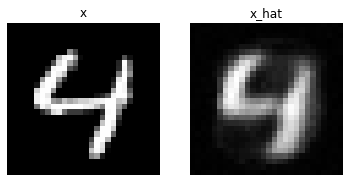

Epoch : 2 / 30, cost : 0.018965791910886765
Epoch : 3 / 30, cost : 0.01132714282721281
Epoch : 4 / 30, cost : 0.007959334179759026
Epoch : 5 / 30, cost : 0.006132069043815136
Epoch : 6 / 30, cost : 0.004992660600692034


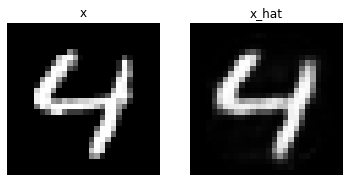

Epoch : 7 / 30, cost : 0.004214531276375055
Epoch : 8 / 30, cost : 0.0036551854573190212
Epoch : 9 / 30, cost : 0.003237406723201275
Epoch : 10 / 30, cost : 0.0029080628883093596
Epoch : 11 / 30, cost : 0.002643084619194269


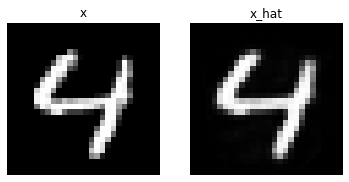

Epoch : 12 / 30, cost : 0.002423156052827835
Epoch : 13 / 30, cost : 0.0022422776091843843
Epoch : 14 / 30, cost : 0.002090419875457883
Epoch : 15 / 30, cost : 0.0019601774401962757
Epoch : 16 / 30, cost : 0.0018468595808371902


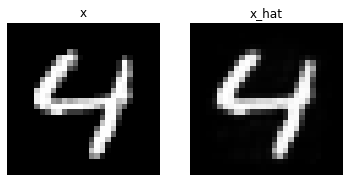

Epoch : 17 / 30, cost : 0.0017482512630522251
Epoch : 18 / 30, cost : 0.001662963884882629
Epoch : 19 / 30, cost : 0.001589144696481526
Epoch : 20 / 30, cost : 0.0015227628173306584
Epoch : 21 / 30, cost : 0.0014644247712567449


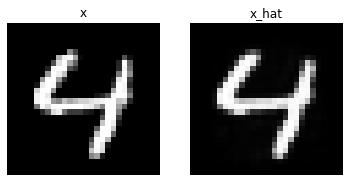

Epoch : 22 / 30, cost : 0.001411821460351348
Epoch : 23 / 30, cost : 0.0013634260976687074
Epoch : 24 / 30, cost : 0.0013215153012424707
Epoch : 25 / 30, cost : 0.0012812218628823757
Epoch : 26 / 30, cost : 0.0012448602356016636


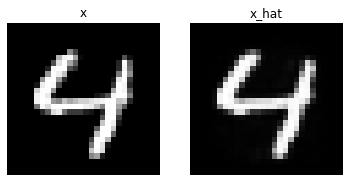

Epoch : 27 / 30, cost : 0.0012113740667700768
Epoch : 28 / 30, cost : 0.001181253232061863
Epoch : 29 / 30, cost : 0.0011518741957843304
Epoch : 30 / 30, cost : 0.0011264639906585217


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

train_dataset = torchvision.datasets.MNIST(root="MNIST_data/",
                                              train=True,
                                              transform=transforms.ToTensor(),
                                              download=True)
test_dataset = torchvision.datasets.MNIST(root="MNIST_data/",
                                            train=False,
                                            transform=transforms.ToTensor(),
                                            download=True)

batch_size = 128

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.linear = nn.Linear(784, 256)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(256, 784)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        return x

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return z, x_hat

model = AutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
sample = test_dataset[1051][0].view(-1, 784).to(device)

epochs = 30

for epoch in range(epochs):
    model.train()
    avg_cost = 0
    total_batch_num = len(train_dataloader)

    for b_x, b_y in train_dataloader:
        b_x = b_x.view(-1, 784).to(device)
        z, b_x_hat = model(b_x) # forward prop
        loss = criterion(b_x_hat, b_x) # get cost

        avg_cost += loss / total_batch_num
        optimizer.zero_grad()
        loss.backward() # backward prop
        optimizer.step() # update parameters

    print('Epoch : {} / {}, cost : {}'.format(epoch+1, epochs, avg_cost))

    # observe differences
    if epoch % 5 == 0:
        model.eval()
        fig, ax = plt.subplots(1,2)
        with torch.no_grad():
            test_z, test_output = model(sample)
        ax[0].set_title('x')
        ax[1].set_title('x_hat')

        ax[0].set_axis_off()
        ax[1].set_axis_off()
        ax[0].imshow(np.reshape(sample.detach().cpu(), (28,28)), cmap='gray')
        ax[1].imshow(np.reshape(test_output.detach().cpu(), (28,28)), cmap='gray')
        plt.show()

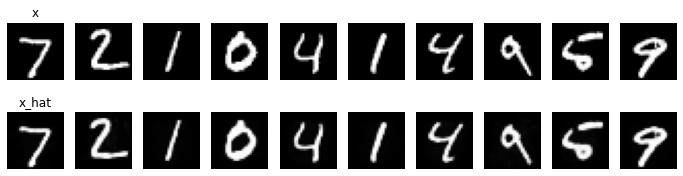

In [6]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
test_samples = torch.zeros((10,28,28))
for i in range(10):
  test_samples[i] = test_dataset[i][0]
test_samples = test_samples.view(-1, 784).to(device)
z, test_output = model(test_samples)

fig, ax = plt.subplots(2, 10, figsize=(12,3))
ax[0][0].set_title('x')
ax[1][0].set_title('x_hat')
for i in range(10):
  ax[0][i].set_axis_off()
  ax[1][i].set_axis_off()
  ax[0][i].imshow(np.reshape(test_samples[i].detach().cpu(), (28,28)), cmap='gray')
  ax[1][i].imshow(np.reshape(test_output[i].detach().cpu(), (28,28)), cmap='gray')
plt.show()